In [19]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import nltk # NLP
import matplotlib.pyplot as plt
from wordcloud import WordCloud # NL
import string
from nltk.corpus import stopwords
import time
#Models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from scipy.sparse import hstack # Concat multiple vectors?

# !pip install wordcloud
# !pip install pandas_profiling

# NLP
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

## Preprocessing 

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_train.columns = ['id', 'job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements','benefits','telecommuting', 'logo', 'questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'doughnuts' , 'fraudulent']
df_test.columns = ['id', 'job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements','benefits','telecommuting', 'logo', 'questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'doughnuts']

In [3]:
# FAST ANALYSIS OF DATA

# profile = ProfileReport(train_df, title="Pandas Profiling Report TRAIN")
# profile.to_file("train.html")
# profile = ProfileReport(train_df.loc[train_df.fraudulent==1], title="Pandas Profiling Report FRAUDULENT TRAIN")
# profile.to_file("fraud_train.html")

### Clean NaN  

#### TRAIN 

In [4]:
# We save a dataframe with all the fraudulent values
subset_frau = df_train[df_train['fraudulent'] == 1]  
subset_frau=subset_frau.drop(["id", "job_id", "doughnuts"], axis=1)


In [5]:
df_train=df_train.drop(["id", "job_id", "doughnuts"], axis=1)
df_train=df_train.dropna(axis=0, thresh=8)
df_train=df_train.dropna(axis=1, thresh=0.35*df_train.shape[0])
np.setdiff1d(subset_frau.columns, df_train.columns) # What columns have we deleted?

array(['salary_range'], dtype=object)

In [6]:
subset_frau=subset_frau.drop(["salary_range"], axis=1)
df_train=pd.concat([df_train, subset_frau])
print(f'Shape of Nan processed train DF {df_train.shape}')
df_train.sample(3)

Shape of Nan processed train DF (11039, 16)


,title,location,department,company_profile,description,requirements,benefits,telecommuting,logo,questions,employment_type,required_experience,required_education,industry,function,fraudulent
1388,Recovery Specialist,"US, NV, Las Vegas",NaN,Tidewater Finance Co. was established in 1992 ...,Tidewater Finance Company is seeking full-time...,The qualifications for this position include: ...,We offer a competitive salary as well as a com...,0,1,1,Full-time,Associate,Unspecified,Financial Services,Customer Service,0
4454,Human Resource Director,"US, TX, AUSTIN",HR,As the industry’s largest supply contracting c...,HR responsibilities for assigned client groups...,Minimum of 6 Months corporate Human Resources...,ALL BENEFITS,0,1,1,Full-time,Director,High School or equivalent,Human Resources,Human Resources,1
5848,VP of Engineering,"US, MI, Detroit",NaN,NaN,A VP of Engineering is responsible for all pro...,Experience:-2+ years Project Management experi...,NaN,0,0,1,Full-time,Director,Bachelor's Degree,NaN,NaN,0


In [7]:
# NaN for Unkown {category}
for (columnName, columnData) in df_train.iteritems():
    name="Unknown {}".format(columnName)
    df_train[columnName] = df_train[columnName].replace(np.nan,name)
df_train.sample(3)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,logo,questions,employment_type,required_experience,required_education,industry,function,fraudulent
4923,Southport Admin Assistant Apprenticeship Under...,"GB, , Southport",Unknown department,Established on the principles that full time e...,Government funding is only available for 16-1...,Full time availability.16-18 year olds only du...,Career prospects.,0,1,1,Full-time,Not Applicable,High School or equivalent,Unknown industry,Administrative,0
8160,"Web developer/Sviluppatore web (Ruby, PHP)","IT, 25, Milano",Unknown department,Xpitality was created by its partners who have...,"Xpitality Srl, a Milan-based company specializ...",Required skills and competenciesStrong knowled...,A chance to contribute to the development of a...,0,1,1,Full-time,Unknown required_experience,Bachelor's Degree,Information Technology and Services,Information Technology,0
8169,Interaction / Interface Designer,"US, CA, San Francisco",Design,Making Quality Metrics ActionableWe are revolu...,We are looking for designers committed to savi...,Bachelors or Masters degree in human computer ...,Insurance reimbursement up to $1000+/mo (depen...,0,1,0,Full-time,Mid-Senior level,Unknown required_education,Internet,Design,0


#### TEST 

In [8]:
df_test=df_test.drop(["id", "job_id", "doughnuts"], axis=1)
df_test=df_test.drop(["salary_range"], axis=1)

for (columnName, columnData) in df_test.iteritems():
    name="Unknown {}".format(columnName)
    df_test[columnName] = df_test[columnName].replace(np.nan,name)

## Text Analysis 

We first need to process our text to eliminate commas, points and all this useless stuff for our model!

In [9]:
def text_process(text, lower=False):
    """text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
        translated any punctuation within text to whitespace, so using replace(' '*4, ' ') 
        is to replace 4 consecutive whitespace to single one, replace(' '*3, ' ')
        from 3 to 1, and so on; then strip to eliminate the whitespaces before & after.

     NECESSARY TO DO THINGS LIKE: Requirements/Qualifications:1 year -> Requirements Qualification 1 year 
    """
    text = text.translate(
    str.maketrans(string.punctuation, ' ' * len(string.punctuation))).replace(
    ' '*4, ' ').replace(' '*3, ' ').replace(' '*2, ' ').strip()
    # Eliminates the stopwords useless for our model
    if lower:
        text = [word.lower() for word in text.split() if word.lower() not in stopwords.words('english')]
    else:
        text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

In [10]:
def wordcloud(df, size=(10,7)):
    """
    Computes the WordCloud of a column of dataframe or saying it in another way, of text values.
    """
    titles_ls = [text for text in df]
    real_all_words = ' '.join(df)
    wordcloud_real = WordCloud(background_color='white',
        width= 800, height= 500,
        max_font_size = 180,
        collocations = False).generate(real_all_words)

    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud_real

Let's process for the train and test data!

In [13]:
start = time.time()
df_train_proc = pd.DataFrame()
cols = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 
            'benefits', 'industry', 'function']
for col in cols:
    df_train_proc[col] = df_train[col].apply(text_process)
    print(f'{col} processed.')
end = time.time()
print(f'{end-start} seconds to compute {cols}')

title processed.
location processed.
department processed.
company_profile processed.
description processed.
requirements processed.
benefits processed.
industry processed.
function processed.
938.7711219787598 seconds to compute ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'industry', 'function']


In [15]:
start = time.time()
df_test_proc = pd.DataFrame()
cols = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 
            'benefits', 'industry', 'function']
for col in cols:
    df_test_proc[col] = df_test[col].apply(text_process)
    print(f'{col} processed.')
end = time.time()
print(f'{end-start} seconds to compute {cols}')

title processed.
location processed.
department processed.
company_profile processed.
description processed.
requirements processed.
benefits processed.
industry processed.
function processed.
593.6556749343872 seconds to compute ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'industry', 'function']


In [17]:
df_train_proc.to_csv('train_text_processed_ALL.csv')
df_test_proc.to_csv('test_text_processed_ALL.csv') # Only 6 [title, dpt, benefits, industry, function, company_profile]

### Split dataset 

In [20]:
selected_cols = ['title', 'industry', 'function', 'department', 'company_profile']
df_train_selected = df_train_proc[selected_cols]
X = df_train_selected
y = df_train.fraudulent
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3, random_state=42)

In [31]:
# How many Unkown for col
for col in selected_cols:
    name = f'Unknown {col}'
    print(f'{col} / Uknown: {df_train[df_train[col]==name].shape[0]}', df_train[col].shape[0] )

title / Uknown: 0 11039
industry / Uknown: 2906 11039
function / Uknown: 3876 11039
department / Uknown: 7134 11039
company_profile / Uknown: 2170 11039


### Vectorize  

In [119]:
def vectorize_df(df, fit=False, vectorizer_cols=None, max_features=0, ngram_range=(1,1)):
    vector_cols = {} # Create a dict with all columns vectors stored in its matrixes
    if fit: vectorizer_cols = {} # Vectorizer learns from one column only. MUST DO IT one by one. FIT PHASE.
    
    for col in df.columns:
        if fit:
#             print('Fitting and Transforming')
            vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
            vectors_col = vectorizer.fit_transform(df[col])
            vectorizer_cols[col] = vectorizer # Store the specific vectorizer.
        else:
#             print('Transforming')
            vectors_col = vectorizer_cols[col].transform(df[col]) # Transform with the vectorizer which we've learnt.
            
        vector_cols[col] = vectors_col
        
    # Stack together all matrixes in one.
#     try:
#         del vectors
#     except:
#         print('Deleted past vectors')
    for i, col in enumerate(vector_cols.keys()):
        if i==0:
            vectors = hstack([vector_cols[col], vector_cols[list(vector_cols.keys())[i+1]]]) # Stack first and second
        else:
            try:
                vectors = hstack([vectors, vector_cols[list(vector_cols.keys())[i+1]]]) # Stack the previous stack with next el.
            except Exception as e:
#                 print(col, i, e) # Out of Range, lazy to put another if
                break
    return vectors, vectorizer_cols

We will try it with a few columns first, the ones we've seen have the more correlation and might better behave! These features are:
* Title
* Industry 1:(Oil/Energy/Accounting)
* Function 1:(Administrative) ; 0:(Information/Tech)
* Dept 1:(Clerical, Engineering)
* Company Profile: (Service/Candidate) !Be careful with Unkwnown here!


In [120]:
train_vectors, vectorizer = vectorize_df(X_train, fit=True)

In [1]:
train_vectors.shape

NameError: name 'train_vectors' is not defined

In [122]:
valid_vectors, _ = vectorize_df(X_valid, fit=False, vectorizer_cols=vectorizer)

In [123]:
valid_vectors.shape

(3312, 16877)

## MODELING

In [125]:
gsc = GridSearchCV(
            estimator=XGBClassifier(random_state=42),
            param_grid={"learning_rate": (0.25, 0.15),
                        "max_depth": [3, 6, 9],
                        "min_child_weight": [ 1, 3]},
            cv=5, scoring='f1', verbose=0, n_jobs=-1)
gsc.fit(train_vectors, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...nehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
       

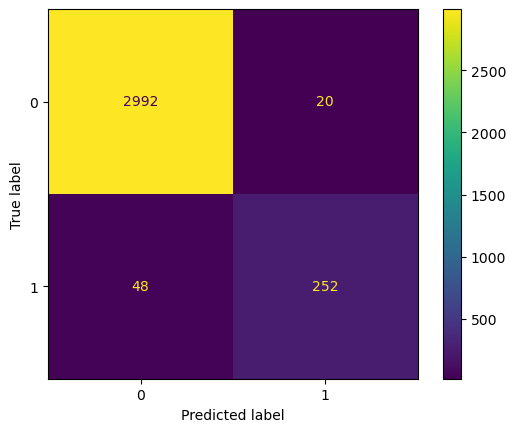

In [127]:
ConfusionMatrixDisplay.from_estimator(gsc, valid_vectors, y_valid)

In [129]:
f1_score(y_valid, gsc.predict(valid_vectors))

0.881118881118881

### PREPARE TEST 

In [134]:
X_test = df_test_proc[selected_cols]

In [135]:
test_vectors, _ = vectorize_df(X_test, fit=False, vectorizer_cols=vectorizer)

In [137]:
test_vectors.shape, X_test.shape

((7152, 16877), (7152, 5))

In [138]:
yhat = gsc.predict(test_vectors)
#Saving the prediction in the Kaggle format.
d = {'Id': range(len(yhat)), 'Category': yhat.astype(int)}
df = pd.DataFrame(data=d)
df.to_csv('submission.csv',index=False)

YES! Good result with only text. Might get better with:
* Questions
* Logo Company